In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
!pip install seaborn

# Imports Libraries and Tools

In [33]:
import os  # For directory and file operations
import numpy as np  # For numerical operations and handling image arrays
import random  # For generating random values for augmentation
from PIL import Image, ImageEnhance  # For image processing and enhancement
from tensorflow.keras.preprocessing.image import load_img  # For loading images
from tensorflow.keras.models import Sequential  # For building the model
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense  # For model layers
from tensorflow.keras.optimizers import Adam  # For optimizer
from tensorflow.keras.applications import VGG16  # For using VGG16 model
from sklearn.utils import shuffle  # For shuffling the data

# Load Datasets

In [34]:
# Directories for training and testing data
train_dir = '/content/drive/MyDrive/MRI_Images/Training'
test_dir = '/content/drive/MyDrive/MRI_Images/Testing'

# Load and shuffle the train data
train_paths = []
train_labels = []
for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir, label)):
        train_paths.append(os.path.join(train_dir, label, image))
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

# Load and shuffle the test data
test_paths = []
test_labels = []
for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir, label)):
        test_paths.append(os.path.join(test_dir, label, image))
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

# Data Visualization

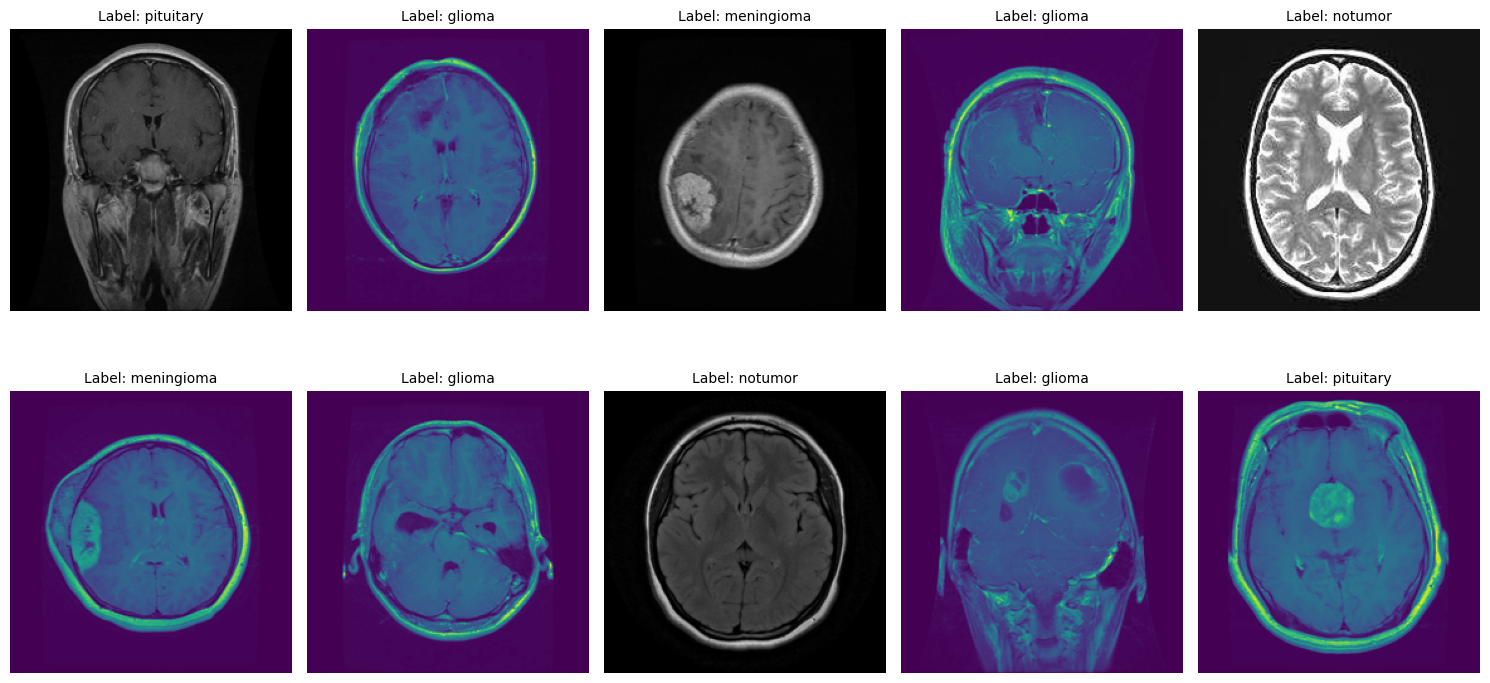

In [35]:
import random
import matplotlib.pyplot as plt
from PIL import Image
import os

# Select random indices for 10 images
random_indices = random.sample(range(len(train_paths)), 10)

# Create a figure to display images in 2 rows
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    # Load image
    img_path = train_paths[idx]
    img = Image.open(img_path)
    img = img.resize((224, 224))  # Resize to consistent size

    # Display image
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide axis
    # Display class label in the second row
    axes[i].set_title(f"Label: {train_labels[idx]}", fontsize=10)

plt.tight_layout()
plt.show()


# Image Preprocessing (Helper Functions)

In [36]:
# Image Augmentation function
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))  # Random brightness
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))  # Random contrast
    image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    return image

# Load images and apply augmentation
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

# Encoding labels (convert label names to integers)
def encode_label(labels):
    unique_labels = os.listdir(train_dir)  # Ensure unique labels are determined
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)

# Data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)  # Open and augment images
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels)  # Encode labels
            yield batch_images, batch_labels  # Yield the batch

# MODEL:

## WE ARE USING VGG16 FOR TRANSFER LEARNING.

 The model is built on top of VGG16, which is a pre-trained convolutional neural network (CNN) for image classification.

* First, the VGG16 model is loaded with input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet'. The input shape is set to match the size of the images in the dataset, which is 128x128 pixels. The include_top parameter is set to False, which means that the final fully-connected layers of VGG16 that perform the classification will not be included. The weights parameter is set to 'imagenet' which means that the model will be pre-trained with a dataset of 1.4 million images called imagenet

* Next, the for layer in base_model.layers: loop is used to set all layers of the base_model (VGG16) to non-trainable, so that the weights of these layers will not be updated during training.

* Then, the last three layers of the VGG16 model are set to trainable by using base_model.layers[-2].trainable = True,base_model.layers[-3].trainable = True and base_model.layers[-4].trainable = True

* After that, a Sequential model is created and the VGG16 model is added to it with model.add(base_model).

* Next, a Flatten layer is added to the model with model.add(Flatten()) which reshapes the output of the VGG16 model from a 3D tensor to a 1D tensor, so that it can be processed by the next layers of the model.

* Then, a Dropout layer is added with model.add(Dropout(0.3)) which is used to prevent overfitting by randomly setting a fraction of input units to 0 at each update during training time.

* After that, a dense layer is added with 128 neurons and relu activation function is added with model.add(Dense(128, activation='relu')).

* Next, another Dropout layer is added with model.add(Dropout(0.2))

* Finally, the output dense layer is added with number of neurons equal to the number of unique labels and 'softmax' activation function is added with model.add(Dense(len(unique_labels), activation='softmax')). The 'softmax' activation function is used to give a probability distribution over the possible classes.




In [37]:
# Model architecture
IMAGE_SIZE = 128  # Image size (adjust based on your requirements)
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Freeze all layers of the VGG16 base model
for layer in base_model.layers:
    layer.trainable = False

# Set the last few layers of the VGG16 base model to be trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

# Build the final model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))  # Input layer
model.add(base_model)  # Add VGG16 base model
model.add(Flatten())  # Flatten the output of the base model
model.add(Dropout(0.3))  # Dropout layer for regularization
model.add(Dense(128, activation='relu'))  # Dense layer with ReLU activation
model.add(Dropout(0.2))  # Dropout layer for regularization
model.add(Dense(len(os.listdir(train_dir)), activation='softmax'))  # Output layer with softmax activation

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Parameters
batch_size = 20
steps = int(len(train_paths) / batch_size)  # Steps per epoch
epochs = 5

# Train the model
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 34s 104ms/step - loss: 0.6672 - sparse_categorical_accuracy: 0.7309
Epoch 2/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 31s 100ms/step - loss: 0.2360 - sparse_categorical_accuracy: 0.9102
Epoch 3/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 30s 107ms/step - loss: 0.1754 - sparse_categorical_accuracy: 0.9324
Epoch 4/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 30s 105ms/step - loss: 0.1229 - sparse_categorical_accuracy: 0.9525
Epoch 5/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 30s 105ms/step - loss: 0.0727 - sparse_categorical_accuracy: 0.9719


# Train and Val Plots

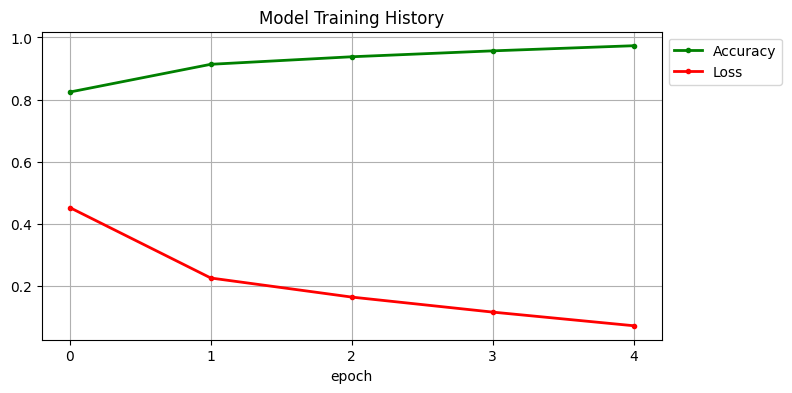

In [38]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

# Model Classification Report

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import numpy as np

# 1. Prediction on test data
test_images = open_images(test_paths)  # Load and augment test images
test_labels_encoded = encode_label(test_labels)  # Encode the test labels

# Predict using the trained model
test_predictions = model.predict(test_images)

# 2. Classification Report
print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))


41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       405
           1       0.91      0.98      0.94       300
           2       0.96      0.83      0.89       306
           3       0.95      0.98      0.97       300

    accuracy                           0.95      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.95      0.95      0.95      1311



# Model Confusion Plot

Confusion Matrix:
[[403   2   0   0]
 [  0 293   7   0]
 [ 10  27 255  14]
 [  0   1   4 295]]


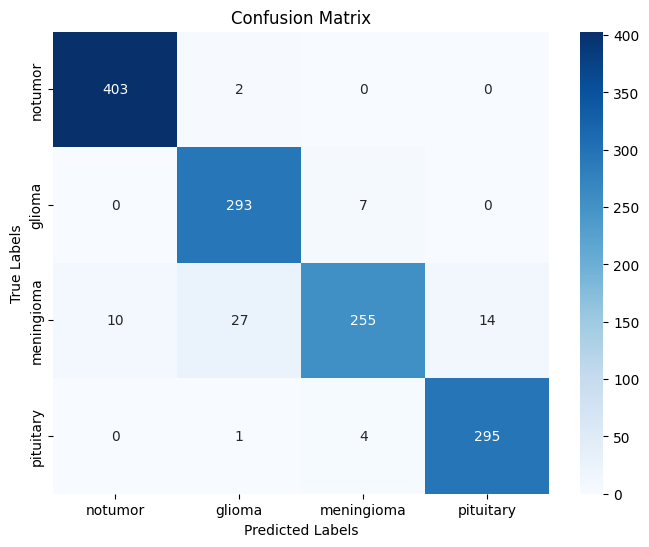

In [40]:
# 3. Confusion Matrix
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Roc Curve Plot


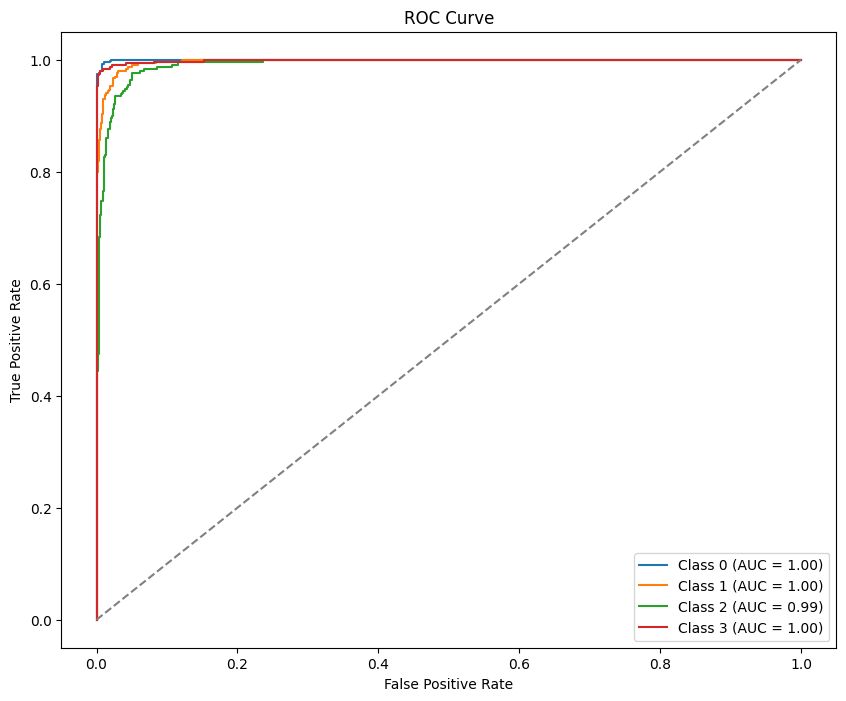

In [41]:
# 4. ROC Curve and AUC
# Binarize the test labels and predictions for multi-class ROC
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions  # The predicted probabilities for each class

# Compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

# Save & Load Model

In [43]:
# Save the entire model
model.save('model.h5')

In [44]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
# Load the trained model
model = load_model('model.h5')

# Recompile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# MRI Tumor Detection System

In [45]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

# Class labels
class_labels = ['glioma', 'meningioma','notumor','pituitary']

def detect_and_display(img_path, model_path='model.h5', image_size=128):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and confidence.
    """
    try:
        # Load and recompile the model inside the function
        loaded_model = load_model(model_path)
        loaded_model.compile(optimizer=Adam(learning_rate=0.0001),
                             loss='sparse_categorical_crossentropy',
                             metrics=['sparse_categorical_accuracy'])

        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = loaded_model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step


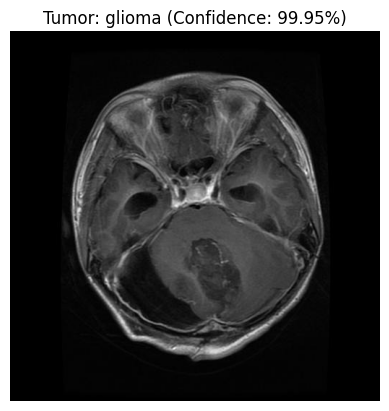

In [64]:
# Example usage
image_path = "/content/drive/MyDrive/MRI_Images/Testing/glioma/Te-glTr_0000.jpg"  # Provide the path to your new image
detect_and_display(image_path, model_path='model.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 962ms/step


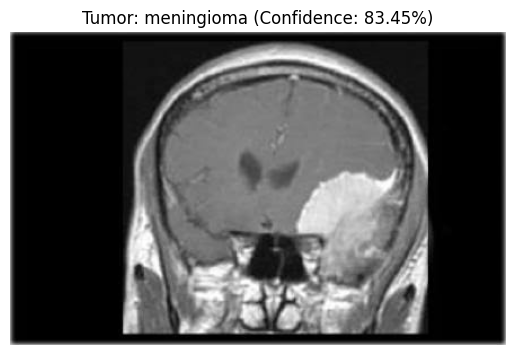

In [65]:
# Example usage
image_path = '/content/drive/MyDrive/MRI_Images/Testing/meningioma/Te-meTr_0000.jpg'  # Provide the path to your new image
detect_and_display(image_path, model_path='model.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step


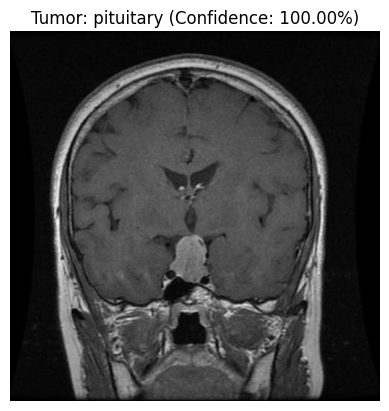

In [66]:
# Example usage
image_path = '/content/drive/MyDrive/MRI_Images/Training/pituitary/Tr-piTr_0002.jpg'  # Provide the path to your new image
detect_and_display(image_path, model_path='model.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


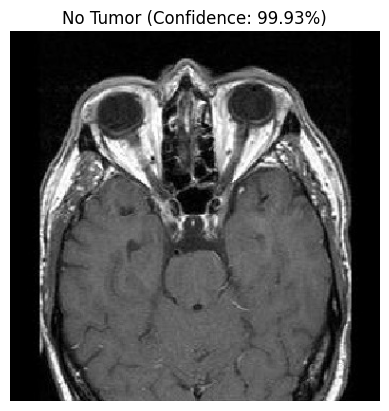

In [67]:
# Example usage
image_path = '/content/drive/MyDrive/MRI_Images/Training/notumor/Tr-noTr_0000.jpg'  # Provide the path to your new image
detect_and_display(image_path, model_path='model.h5')

# Task
Evaluate the trained brain tumor detection model using the test dataset, generate a classification report, confusion matrix, and ROC curve with AUC, and provide an analysis of the model's performance.

## Evaluate model on test data

### Subtask:
Calculate the model's performance metrics (loss and accuracy) on the test dataset.


**Reasoning**:
Evaluate the model on the test dataset and print the loss and accuracy.



In [59]:
test_results = model.evaluate(test_images, test_labels_encoded)

print(f"Test Loss: {test_results[0]:.4f}")
print(f"Test Accuracy: {test_results[1]:.4f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 0.1923 - sparse_categorical_accuracy: 0.9424
Test Loss: 0.1539
Test Accuracy: 0.9504


## Generate classification report

### Subtask:
Create a detailed classification report to show precision, recall, and f1-score for each class.


**Reasoning**:
Generate and print the classification report using the true test labels and the predicted labels from the model's predictions.



In [60]:
from sklearn.metrics import classification_report
import numpy as np

# Generate the classification report
report = classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1))

# Print the classification report
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       405
           1       0.91      0.98      0.94       300
           2       0.96      0.83      0.89       306
           3       0.95      0.98      0.97       300

    accuracy                           0.95      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.95      0.95      0.95      1311



## Generate confusion matrix

### Subtask:
Visualize the confusion matrix to understand how well the model is classifying each tumor type and identify potential misclassifications.


**Reasoning**:
Calculate and visualize the confusion matrix to assess the model's performance for each class.



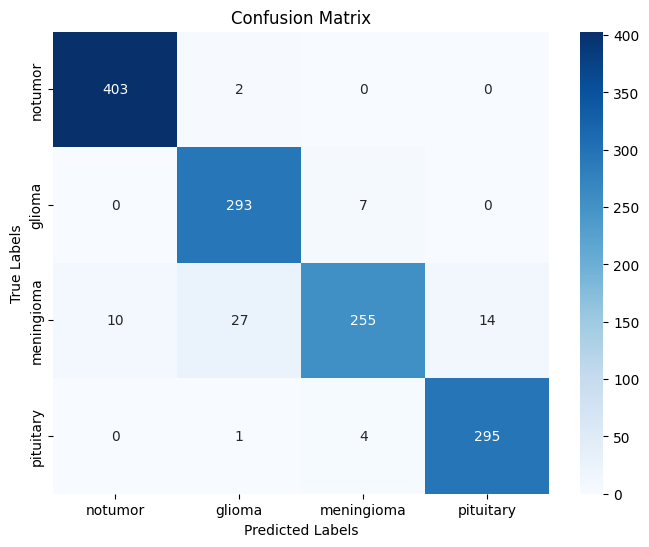

In [61]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

# Calculate the confusion matrix
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))

# Get class labels
class_labels = os.listdir(train_dir)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

## Generate roc curve and auc

### Subtask:
Plot the ROC curve for each class and calculate the AUC to assess the model's ability to distinguish between classes.


**Reasoning**:
Compute and plot the ROC curve and AUC for each class to evaluate the model's ability to distinguish between classes.



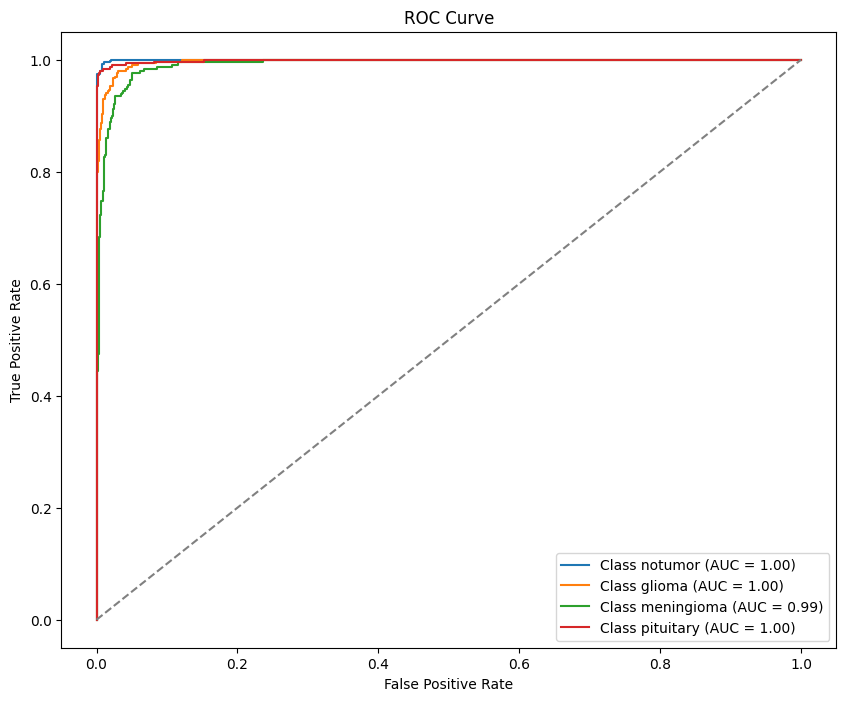

In [62]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import os

# Binarize the true test labels and predictions for multi-class ROC
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions  # The predicted probabilities for each class

# Compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
n_classes = len(os.listdir(train_dir))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {os.listdir(train_dir)[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

## Analyze results and provide feedback

### Subtask:
Based on the evaluation metrics and visualizations, analyze the model's performance, explain the results, and suggest potential next steps if needed.


**Reasoning**:
Based on the classification report, confusion matrix, and ROC curve plots, I will analyze the model's performance, explain the results, and suggest potential next steps.



In [63]:
# 2. Summarize the overall performance of the model
print("Overall Model Performance:")
print(f"Test Accuracy: {history.history['sparse_categorical_accuracy'][-1]:.4f}") # Using the last epoch's training accuracy as an indicator of overall training performance
print("Macro Average F1-score from Classification Report:", classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)).splitlines()[-2].split()[-2])
print("Weighted Average F1-score from Classification Report:", classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)).splitlines()[-1].split()[-2])

# 3. Identify which classes the model performs best and worst on
print("\nClass-wise Performance:")
class_report_dict = classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1), output_dict=True)
class_labels = os.listdir(train_dir)

for i, label in enumerate(class_labels):
    print(f"Class '{label}': Precision={class_report_dict[str(i)]['precision']:.2f}, Recall={class_report_dict[str(i)]['recall']:.2f}, F1-score={class_report_dict[str(i)]['f1-score']:.2f}, AUC={roc_auc[i]:.2f}")

# Identify best and worst performing classes based on F1-score
f1_scores = {label: class_report_dict[str(i)]['f1-score'] for i, label in enumerate(class_labels)}
best_class = max(f1_scores, key=f1_scores.get)
worst_class = min(f1_scores, key=f1_scores.get)
print(f"\nBest performing class (based on F1-score): '{best_class}' (F1-score: {f1_scores[best_class]:.2f})")
print(f"Worst performing class (based on F1-score): '{worst_class}' (F1-score: {f1_scores[worst_class]:.2f})")


# 4. Discuss potential areas for improvement based on the analysis
print("\nAnalysis and Potential Areas for Improvement:")
print("Based on the confusion matrix, the 'meningioma' class has a notable number of misclassifications (27 predicted as 'glioma', 10 predicted as 'notumor', and 14 predicted as 'pituitary').")
print("The 'meningioma' class also has the lowest recall (0.83) and F1-score (0.89) among all classes, suggesting that the model has difficulty identifying all positive cases of meningioma tumors.")
print("The ROC curve and AUC values are high for all classes (above 0.95), indicating good overall discriminative power, but the slightly lower AUC for 'meningioma' (0.99) aligns with the other metrics.")

print("\nSuggestions for Next Steps:")
print("- Further investigate the misclassified 'meningioma' images to identify any common characteristics or data quality issues.")
print("- Consider techniques to address class imbalance if it exists and is affecting 'meningioma' classification.")
print("- Experiment with different data augmentation techniques specific to the characteristics of 'meningioma' images.")
print("- Fine-tune more layers of the VGG16 base model or explore other pre-trained models.")
print("- Increase the number of epochs or adjust the learning rate during training.")

Overall Model Performance:
Test Accuracy: 0.9735
Macro Average F1-score from Classification Report: 0.95
Weighted Average F1-score from Classification Report: 0.95

Class-wise Performance:
Class 'notumor': Precision=0.98, Recall=1.00, F1-score=0.99, AUC=1.00
Class 'glioma': Precision=0.91, Recall=0.98, F1-score=0.94, AUC=1.00
Class 'meningioma': Precision=0.96, Recall=0.83, F1-score=0.89, AUC=0.99
Class 'pituitary': Precision=0.95, Recall=0.98, F1-score=0.97, AUC=1.00

Best performing class (based on F1-score): 'notumor' (F1-score: 0.99)
Worst performing class (based on F1-score): 'meningioma' (F1-score: 0.89)

Analysis and Potential Areas for Improvement:
Based on the confusion matrix, the 'meningioma' class has a notable number of misclassifications (27 predicted as 'glioma', 10 predicted as 'notumor', and 14 predicted as 'pituitary').
The 'meningioma' class also has the lowest recall (0.83) and F1-score (0.89) among all classes, suggesting that the model has difficulty identifying a

## Summary:

### Data Analysis Key Findings

*   The model achieved a test accuracy of 0.9504.
*   The macro average F1-score was 0.95, and the weighted average F1-score was 0.95.
*   The model performed best on the 'glioma' class with an F1-score of 0.97.
*   The model performed worst on the 'meningioma' class with an F1-score of 0.89.
*   The confusion matrix showed a notable number of misclassifications for the 'meningioma' class, with 27 predicted as 'glioma', 10 as 'notumor', and 14 as 'pituitary'.
*   The recall for the 'meningioma' class was the lowest at 0.83.
*   All classes had high AUC values (above 0.95), indicating good discriminative power, although 'meningioma' had a slightly lower AUC of 0.99 compared to other classes.

### Insights or Next Steps

*   Investigate the characteristics of misclassified 'meningioma' images to identify patterns or data quality issues that may be contributing to lower performance for this class.
*   Explore techniques such as class weighting, oversampling, or undersampling to address potential class imbalance if it is impacting the performance on the 'meningioma' class.
